# Modeling Notebook

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import re
import datetime as dt
import random
import pickle
import shutil
import subprocess

# opencv
import cv2

# tensorflow/keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Lambda, Concatenate,Flatten, concatenate, LSTM, MaxPooling2D, Permute, Reshape, TimeDistributed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
# import resnet
from tensorflow.keras.applications import ResNet50

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

# custom
from utilities import extract_position_time, normalize_datetime, \
normalize_y, get_lat_long_bounds, normalize_times, un_normalize, \
confidence_ellipse

from image_generator import get_waypoints

In [133]:
files_train = os.listdir('../images/train')
files_train = [f for f in files_train if f.endswith('.png')]

# files_val = os.listdir('../images/valid')
# files_val= [f for f in files_val if f.endswith('.png')]

files = files_train 

# create array of position
position = np.array([extract_position_time(f)[0] for f in files])

# create array of time
times = np.array([extract_position_time(f)[1] for f in files])

# Loss Functions

There is a non-linear relationship between Latitude and Longitude. Rather than use Root Mean Square Error or another more commonly used ML metric, we can use two methods of determing a distance between sets of positions, great circle distance or mercator distance. 

Great Circle

In [134]:
def haversine_loss(y_true, y_pred, R=3440):

    # un-normalize the lat and long
    lat_min, lat_range, long_min, long_range = get_lat_long_bounds(position)
    lat1  = y_true[:,0] * lat_range + lat_min
    lat2  = y_pred[:,0] * lat_range + lat_min
    long1 = y_true[:,1] * long_range + long_min
    long2 = y_pred[:,1] * long_range + long_min 
    
    # Compute phis and lambdas 
    phi1 = lat1 * np.pi / 180
    phi2 = lat2 * np.pi / 180
    delta_phi    = (lat2 - lat1) * np.pi / 180
    delta_lambda = (long2 - long1) * np.pi / 180
    
    # Intermediate computations
    a = tf.square(tf.sin(delta_phi / 2)) + tf.cos(phi1) * tf.cos(phi2) * tf.square(tf.sin(delta_lambda / 2))
    c = 2 * tf.atan2(tf.sqrt(a), tf.sqrt(1 - a))
    
    # Compute distances
    d = R * c

    return tf.reduce_mean(d)


def haversine_loss_2_nautical_miles(y_true, y_pred):
    R = 3440  # radius of Earth in nautical miles
    lat1, lon1 = np.deg2rad(y_true[:, 0]), np.deg2rad(y_true[:, 1])
    lat2, lon2 = np.deg2rad(y_pred[:, 0]), np.deg2rad(y_pred[:, 1])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


Mercator

In [135]:
def mercator_loss(y_true, y_pred):
    # Convert normalized lat and long into actuals
    lat_min, lat_range, long_min, long_range = get_lat_long_bounds(position)
    lat1  = y_true[:,0] * lat_range + lat_min
    lat2  = y_pred[:,0] * lat_range + lat_min
    long1 = y_true[:,1] * long_range + long_min
    long2 = y_pred[:,1] * long_range + long_min

    # compute meridional parts
    mpartsinitial = 7915.7045 * np.log10(
                np.tan(np.pi / 4 + (np.deg2rad(lat1) / 2))) - 23.2689 * np.sin(
                np.deg2rad(lat1))
    mpartssecond = 7915.7045 * np.log10(np.tan(np.pi / 4 + (np.deg2rad(lat2) / 2))) - 23.2689 * np.sin(
                np.deg2rad(lat2))
                
    little1 = (mpartssecond - mpartsinitial) 
    
    # compute dlat
    dlat = np.deg2rad(lat2 - lat1)

    # compute dlong
    dlong = np.deg2rad(long2 - long1)

    # compute course
    course = np.arctan2(dlong,np.deg2rad(little1/60))

    # compute distance
    d = np.rad2deg(dlat/np.cos(course)) * 60

    return tf.reduce_mean(d)

# Generator Functions

In [136]:
class CustomGenerator(Sequence):
    def __init__(self, directory, batch_size=32, segment = 'Train'):
        
        self.directory = directory
        self.batch_size = batch_size
        self.segment = segment

    def __len__(self):
      if self.segment !='Train':
        return int(np.floor(len(files_val) / self.batch_size))
      else:
        return int(np.floor(len(files_train) / self.batch_size))


    def __getitem__(self, idx):

        # get batch of images
        batch = os.listdir(self.directory)[idx * self.batch_size:(idx + 1) * self.batch_size]
        # create empty array to hold images
        # batch.sort()
        x = np.empty((self.batch_size, 224, 224, 1))
        y = np.zeros((self.batch_size, 2))
        times_gen = []
        # loop through batch
      
        for i, img in enumerate(batch):
            # populate time and position labels 
            y[i] = extract_position_time(img)[0]
            time = extract_position_time(img)[1]
            times_gen.append(normalize_datetime(time, times.min(), times.max()))
             # read image
            img = cv2.imread(os.path.join(self.directory, img),0)
            img = cv2.resize(img, (224, 224))
            # add image to x
            x[i] = img.reshape(224, 224, 1)

        # get output
        output = normalize_y(y, position)
           
        # get time input
        time_input = np.array(times_gen) 
        
        return [x/255, time_input], output

custom_gen_train = CustomGenerator(directory = '../images/train', segment = 'Train')
custom_gen_val = CustomGenerator(directory = '../images/valid', segment = 'Validate')

# Models

I. Production Model, CNN/LSTM

In [137]:
# define the input layers
input_image = Input(shape=(224,224,1))
input_time = Input(shape=times[0].shape)

# drocess the input image using a CNN
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(input_image)
x = MaxPooling2D()(x)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = Flatten()(x)

# reshape input_time 
t = tf.keras.layers.Reshape(target_shape=(1, 1))(input_time)

# process the input time using LSTM layers
t = LSTM(32, return_sequences=True)(t)
t = LSTM(16)(t)

# concatenate the output of the CNN and LSTM layers
z = tf.keras.layers.concatenate([x, t], axis=-1)

# z = concatenate([x, t])
z = Dense(256, activation='relu')(z)
z = Dropout(0.2)(z)
outputs = Dense(2, activation='sigmoid')(z)

# define the model
model_main = Model(inputs=[input_image, input_time], outputs=outputs)
model_main.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 224, 224, 32  320         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 112, 112, 32  0          ['conv2d_12[0][0]']              
                                )                                                           

II. Montecarlo Dropout Layers

# Model Topology

The final production classification model is a multi-input deep learning model that takes an image with accompanying time series data as inputs and outputs a predicted latitude and longitude.

The image input is processed by a convolutional neural network consisting of 3 Conv2D layers follwed by MaxPooling 2D layers and a Flatten layer to reduce the image dimensions. The time-series input is reshaped by a reshape layer then processed by 2 LSTM layers. The output of the CNN and LSTM layers are concatenated and processed by 2 fully connected dense layers with 256 neurons and ReLU activation functions. The model uses Monte Carlo Dropout layers with a dropout rate of 0.2 to add uncertainty to the model predictions. The final layer is a dense layer with 2 neurons and a sigmoid activation function, which yields predicted latitude and longitude values. 

### Sigmoid Function as Output

The sigmoid activation function is commonly used in binary classification problems, where the output is between 0 and 1, and the value represents the probability of a given instance belong to 1 of 2 classes. 

In this specific use case, the final dense layer has 2 neurons and sigmoid activation will output two values between 0 and 1, which are the normalized predictions for latitude and longitude. To recover latitude and longitude we simply un-normalize these values using the values we used to normalize the training data. 

### MC Dropout

Normal dropout layers only dropout at training time, and serve as regularization to curb overfitting. For prediction time, the dropout is not applied and all nodes/connections are present. The model is thus deterministic: it will make the same prediction every time. 

For Monte Carlo dropout, the dropout is applied during training and during prediction time. Thus the prediction is no longer determinisitic but is now dependent on the nodes and links that were randomly chosen to be kept, and as a result, we will get a different prediction every time the model runs. 

The utility of this process is that we can now interpret the output of the model in a probabilistic way. A predicted position is no longer a single prediction, but is instead the mean of 100 predictions for the image, and from this distribution of predictions we are able to fix the position with a specified degree of statistical confidence and present the results visually with a confidence ellipse. 


In [151]:
# from tensorflow.keras.layers import Layer
class MCdropout(Dropout):
    # code from this source: https://towardsdatascience.com/monte-carlo-dropout-7fd52f8b6571
    def call(self, inputs):
        return super().call(inputs, training=True)

input_image = Input(shape=(224,224,1))
input_time = Input(shape=times[0].shape)

# process the input image using a CNN
x = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(input_image)
x = MaxPooling2D()(x)
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = Flatten()(x)

# reshape input time
t = tf.keras.layers.Reshape(target_shape=(-1, 1))(input_time)

# process the input time using LSTM layers
t = LSTM(16, return_sequences=True)(t)
t = LSTM(32)(t)

# concatenate the output of the CNN and LSTM layers
z = concatenate([x, t])
z = Dense(256, activation='relu')(z)
z = MCdropout(0.2)(z) # MC Dropout layer
z = Dense(256, activation='relu')(z)
z = MCdropout(0.2)(z) # MC Dropout layer

# define the output layer
outputs = Dense(2, activation='sigmoid')(z)

mcmodel = Model(inputs=[input_image, input_time], outputs=outputs)

# Load Models

In [ ]:
# load monte carlo model using custom_object_scope
with tf.keras.utils.custom_object_scope({'haversine_loss': haversine_loss, 'MCdropout': MCdropout}):
    mcmodel = tf.keras.models.load_model('../models/mc_model.h5')

# Predictions

In [153]:

path = '../images/voyage_sims/voyages/30/' 

def predict_positions(path, model, model_type = 'reg'):
    files_voy = os.listdir(path)
    files_voy = [f for f in files_voy if f.endswith('.png')]
    X_voy = np.zeros((len(files_voy), 224, 224))

    for i, f in enumerate(files_voy):
        img = cv2.imread(path + f, 0)
        img = cv2.resize(img, (224, 224))
        img
        X_voy[i] = img
        
    X_voy = np.expand_dims(X_voy/255, 3)

    # create array of voyage positions
    position_voy = np.array([extract_position_time(f)[0] for f in files_voy])
    # create array of voyage times
    times_voy = np.array([extract_position_time(f)[1] for f in files_voy])
    # normalize voyage positions
    y_voy = normalize_y(position_voy, master_pos = position  )
    # normalize voyage times
    t_voy = normalize_times(times_voy, master_times = times)

    if model_type == 'mcmodel':
        predictions = []
        for i in range(100):
            # print('MC prediction: ', i, '/30')
            predictions.append(mcmodel.predict([X_voy, t_voy], verbose=0))
        predictions = np.array(predictions)
        stds = np.std(predictions, axis=0)
        y_pred = np.mean(predictions, axis=0)
    else:
        # predict voyage positions
        y_pred = model.predict([X_voy, t_voy])

    # get lat and long bounds to unnormalize
    lat_min, lat_range, long_min, long_range = get_lat_long_bounds(position)

    # unnormalize predicted and actual positions
    pred_pos = un_normalize(y_pred, lat_range, lat_min, long_range, long_min)
    act_pos = un_normalize(y_voy, lat_range, lat_min, long_range, long_min)

    pos = pd.DataFrame()

    pos['time'] = times_voy
    pos['pred_lat'] = pred_pos[:,0]
    pos['pred_long'] = pred_pos[:,1]
    pos['actual_lat'] = act_pos[:,0]
    pos['actual_long'] = act_pos[:,1]
    pos['Error'] = haversine_loss_2 (act_pos, pred_pos)

    # mean
    print('Mean Position Error: {:0.2f} NM'.format(pos['Error'].mean()))
    # std
    print('Standard Deviation of Position Error: {:0.2f} NM'.format(pos['Error'].std()))
    return pred_pos, act_pos, pos['Error'].std()

In [154]:
preds = predict_positions(path, mcmodel, model_type = 'mcmodel')

Mean Position Error: 0.89 NM
Standard Deviation of Position Error: 0.59 NM


In [155]:
files_voy = os.listdir(path)
files_voy = [f for f in files_voy if f.endswith('.png')]
X_voy = np.zeros((len(files_voy), 224, 224))

for i, f in enumerate(files_voy):
    img = cv2.imread(path + f, 0)
    img = cv2.resize(img, (224, 224))
    img
    X_voy[i] = img
    
X_voy = np.expand_dims(X_voy/255, 3)

# create array of voyage positions
position_voy = np.array([extract_position_time(f)[0] for f in files_voy])
# create array of voyage times
times_voy = np.array([extract_position_time(f)[1] for f in files_voy])
# normalize voyage positions
y_voy = normalize_y(position_voy, master_pos = position  )
# normalize voyage times
t_voy = normalize_times(times_voy, master_times = times)


preds_mc = []


lat_min, lat_range, long_min, long_range = get_lat_long_bounds(position)
for x in range(len(X_voy)):
    intermediate_preds = []
    for i in range(100):
        image = X_voy[x]
        time = t_voy[x]
        image = np.expand_dims(image, 0)
        time = np.expand_dims(time, 0)
        y_pred = mcmodel.predict([image, time], verbose=0)
        pred_pos = un_normalize(y_pred, lat_range, lat_min, long_range, long_min)
        intermediate_preds.append(pred_pos)
    preds_mc.append(np.array(intermediate_preds))

act_pos = un_normalize(y_voy, lat_range, lat_min, long_range, long_min)

mean_latitudes = [preds_mc[i][:,0][:,0].mean() for i in range(len(preds_mc))]
mean_longitudes = [preds_mc[i][:,0][:,1].mean() for i in range(len(preds_mc))]

monte_carlo_df = pd.DataFrame()
monte_carlo_df['time'] = times_voy
monte_carlo_df['pred_lat'] = mean_latitudes
monte_carlo_df['pred_long'] = mean_longitudes
monte_carlo_df['actual_lat'] = act_pos[:,0]
monte_carlo_df['actual_long'] = act_pos[:,1]
monte_carlo_df['Error'] = haversine_loss_2 (act_pos, np.array([mean_latitudes, mean_longitudes]).T)


In [189]:

monte_carlo_df.sort_values(by='time', inplace=True)
print(monte_carlo_df['Error'].mean())
print(monte_carlo_df['Error'].std())

1.0252007268134493
0.33477459621496825


In [201]:

def plot_lat_long(y_pred, y_true, show_track = False):
    %matplotlib inline
  
    # create figure and axes
    fig, ax = plt.subplots(figsize=(8,8))

    if show_track !=False:
        start = (39, -140)
        end = (37, -138)
        # get waypoints
        waypoints = get_waypoints(start, end, 10, list_of_mile_displacements=[0])
        # use '+' symbol for waypoints
        ax.plot(waypoints[:,1], waypoints[:,0], 'k+', markersize=10, label='Waypoints')

    # use seaborn darkgrid
    sns.set_style("darkgrid")
    # ax.scatter(y_pred[:, 1],y_pred[:, 0], label='predicted', color = 'blue', alpha = 0.8, marker = 'o')
    ax.scatter(y_true[:, 1],y_true[:, 0], label='actual', color = 'red', marker='x')
    # ax.legend()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Predicted vs. Actual Position Prediction use Monte Carlo Dropout')

    # color dictionary
    
    for i in range(len(preds_mc)):
        # plot all the predictions
        # change color for each prediction
    
        ax.scatter(preds_mc[i][:,0][:,1], preds_mc[i][:,0][:,0], color='blue', alpha=0.05, s = 10)

        # plot mean
        ax.scatter(preds_mc[i][:,0][:,1].mean(), preds_mc[i][:,0][:,0].mean(), color='blue', alpha=1.0, marker='o', s=10)
        
        confidence_ellipse(preds_mc[i][:,0][:,0], preds_mc[i][:,0][:,1], ax, n_std=2.0, edgecolor='green', linestyle=':')

        # add time label
        ax.text(preds_mc[i][:,0][:,1].mean() + .005, preds_mc[i][:,0][:,0].mean(), monte_carlo_df['time'][i], fontsize=8)
        
    # add confidence ellipse to legend
    ax.legend(['Actual', 'Monte Carlo Positions','Predicted', 'Two Sigma Ellipse'])


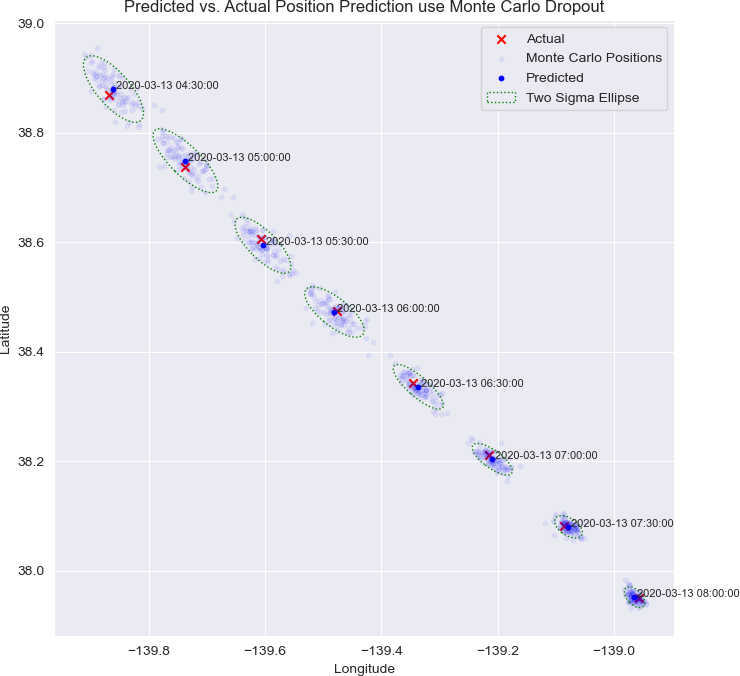

In [202]:
plot_lat_long(preds[0], preds[1]);

# Position Fixing With Confidence Ellipses

The production model predicts a position by iterating over an image of the sky 100 times. The Monte Carlo Dropout layers make multiple forward passes with different dropout masks, creating 100 different position predictions for each image. The resulting arrays of predicted latitudes and longitudes are used to calculate a covariance matrix for the position. From the covariance matrix, a confidence ellipse is rendered via Eigendecomposition and scaling. The steps are as follows:


1. Decompose the covariance matrix into eigenvalues and eigenvectors: The covariance matrix is a symmetric matrix, so it can be decomposed into a set of eigenvalues and eigenvectors, which describe the magnitude and direction of the variances in the data.

2. Determine the confidence level: A confidence level of .95 was chosen for the model. 

3. Scale the eigenvectors: The eigenvectors are scaled by the square root of the eigenvalues and multiplied by a factor corresponding to the desired confidence level. This gives the semi-axes of the ellipse.

4. Plot the ellipse: The scaled eigenvectors are used to define the axes of the ellipse, and the center of the ellipse is located at the mean of the predicted latitudes and longitudes. The ellipse is then plotted, representing the region in which the data is expected to fall with the desired level of confidence.

5. The resulting confidence ellipse provides a visual representation of the uncertainty of the predicted position, with the most probable position located within the ellipse. 
